# Relevance between movies based on their subtitles
The intention in this notebook is to use movie subtitles to make recommendations based on a semantic relevance check or as a previous step for another algorithm.

A collaboration between Carlos Martinez and Santos Bañuelos.

Relevant Sources:
   * [Parts of speech](https://www.englishclub.com/grammar/)
   * [Tf-Idf](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
   * [Tf-idf Document similarity](http://stackoverflow.com/questions/8897593/similarity-between-two-text-documents)
   * [Tf-idf Relevant documents](http://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity)
   * [Using latent semantic analysis](http://stackoverflow.com/questions/18997905/use-latent-semantic-analysis-with-sklearn#18999170)
   * [Dictionary module used for checking a word membership to the english language](http://pythonhosted.org/pyenchant/)
   * [Base for the plotting function](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
   * [Subtitles source](http://www.yifysubtitles.com/)

In [1]:
from collections import Counter, OrderedDict
from matplotlib import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import time

%matplotlib inline

## Plotting

In [2]:
def plot_confusion_matrix(subtitles_data, movies_names, title='Relevance between movies', cmap=plt.cm.Blues):
    plt.figure(figsize=(len(movies_names)//2, len(movies_names)//2))
    plt.imshow(subtitles_data, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.clim(1.0,0.0)
    plt.colorbar()
    tick_marks = np.arange(len(movies_names))
    plt.xticks(tick_marks, movies_names, rotation='vertical')
    plt.yticks(tick_marks, movies_names)
    thresh = subtitles_data.max() / 2.0
    i_index = 0
    for i, j in itertools.product(range(subtitles_data.shape[0]), range(subtitles_data.shape[1])):
        if i_index < i:
            j_max = np.argsort(subtitles_data[i_index])[::-1][1]
            plt.text(j_max, i_index, '{:.2f}'.format(subtitles_data[i_index, j_max]),
                 horizontalalignment="center", color="red").set_fontsize(8)
            j_max = np.argsort(subtitles_data[i_index])[::-1][2]
            plt.text(j_max, i_index, '{:.2f}'.format(subtitles_data[i_index, j_max]),
                 horizontalalignment="center", color="magenta").set_fontsize(8)
            i_index += 1
        plt.text(j, i, '{:.2f}'.format(subtitles_data[i, j]),
                 horizontalalignment="center",
                 color="white" if subtitles_data[i, j] > thresh else "black").set_fontsize(8)
    plt.show()

This function plots a confusion matrix, it highligths the highest value that is not 1.0, also the name of the movie and their number inside the subtitles array for an easier histogram plotting, remember to substract 1 from its index to obtain the correct position.

In [3]:
def plot_histogram(text, title='', number_of_words=50, display_word_count=True, sort_by_word_count=True, increasing=False):
    if display_word_count == True:
        print('Words Title')
        print('{} {}'.format(len(set(text.split())), title))
    labels, y = zip(*sorted(Counter(text.split()).items(), key=lambda p:p[sort_by_word_count], reverse=not(increasing)))
    x, width = np.arange(number_of_words), 0.3
    plt.figure(figsize=(18, 5))
    plt.suptitle(title)
    plt.bar(x[0:number_of_words], y[0:number_of_words], width)
    plt.xticks(x, labels, rotation='vertical')
    plt.show()

This function plots an histogram of a given subtitle text, it lets the user select the number of words to display and also sort them by their frequency or the alphabetical order.

## Processing

In [4]:
#Regex
regex_filter = re.compile(r'\b([\d]+|\:|,)\b|[\<][\d\s\w\+\:\?\®\©\-\/\#\=\"]+[\>]|[->]+|[\.\®\©\'\,\?\\\!\/\#\:\;\&\%\$\*\—\@]+|[\{\(\[]+[\s\w]*[\]\)\}]+|[\[\]\(\)\{\}]+|(\b(\w|\d|a|aboard|about|above|abroad|absolutely|accidentally|across|after|against|ah|alas|all|almost|along|already|although|always|amid|among|an|and|angrily|annually|another|anti|anxiously|any|anybody|anyone|anything|anywhere|around|as|at|away|awfully|awkwardly|back|backward|backwards|badly|barely|beautifully|because|before|behind|below|beneath|beside|besides|between|beyond|blindly|boldly|both|bravely|brightly|busily|but|by|calmly|carefully|carelessly|cautiously|cheerfully|clearly|closely|completely|concerning|considering|constantly|correctly|courageously|cruelly|daily|daringly|dear|decidedly|deeply|deliberately|despite|doubtfully|down|downstairs|during|each|eagerly|earlier|early|easily|east|eh|either|elegantly|elsewhere|enormously|enough|enthusiastically|entirely|equally|er|etc|eventually|ever|every|everybody|everyone|everything|exactly|except|excepting|excluding|extremely|fairly|faithfully|far|fast|fatally|few|fewer|fewest|fiercely|finally|first|following|fondly|foolishly|for|formerly|fortnightly|fortunately|frankly|frantically|frequently|from|fully|generally|generously|gently|gladly|gracefully|greatly|greedily|happily|hard|hardly|hastily|he|healthily|hello|her|here|hers|herself|hey|hi|highly|him|himself|his|hm|hmm|honestly|hourly|how|huh|hullo|hungrily|hurriedly|i|if|in|inadequately|incredibly|indeed|indoors|infrequently|ingeniously|innocently|inquisitively|inside|intensely|into|irritably|it|its|itself|joyously|just|justly|kindly|last|late|lately|later|lazily|least|less|like|little|loosely|lots|loudly|madly|many|me|mine|minus|monthly|more|mortally|most|much|my|myself|mysteriously|near|nearby|nearly|neatly|neither|nervously|never|next|nightly|no|nobody|noisily|none|nor|normally|nothing|now|o|obediently|occasionally|of|off|often|oh|on|once|one|onto|openly|opposite|or|other|others|ouch|our|ours|ourselves|out|outside|over|painfully|past|patiently|per|perfectly|plus|politely|poorly|positively|powerfully|practically|pretty|previously|promptly|punctually|purely|quarterly|quickly|quietly|quite|rapidly|rarely|rather|really|recently|recklessly|regarding|regularly|reluctantly|repeatedly|rightfully|roughly|round|rudely|sadly|safely|save|scarcely|seldom|selfishly|sensibly|seriously|several|sharply|she|shyly|silently|simply|since|sleepily|slowly|smoothly|so|softly|solemnly|some|somebody|someone|something|sometimes|somewhat|soon|speedily|stealthily|sternly|still|straight|strongly|stupidly|successfully|such|suddenly|suspiciously|swiftly|tenderly|tensely|terribly|than|that|the|their|theirs|them|themselves|then|there|these|they|this|thoroughly|those|though|thoughtfully|through|tightly|till|to|today|tomorrow|tonight|too|totally|toward|towards|truthfully|uh|um|umm|under|underneath|unexpectedly|unlike|until|up|upon|upstairs|us|usually|utterly|versus|very|via|victoriously|violently|virtually|vivaciously|warmly|we|weakly|wearily|weekly|well|what|when|where|whether|which|while|who|whom|whose|wildly|wisely|with|within|without|yearly|yesterday|yet|you|your|yours|yourself|yourselves|re|do|not|don|ll|is|are|ve|am|was|were|aren|au|de|didn|ida|doed|doesn|wh|whoo|whooee|whooe|whoooo|wow|wxbx|yo|ya|ma|may|maybe|m|mm|mmm|mon|nada|ogo|lo|ja|isn|im|ill|hoo|ohh|ooh|who|doin|else|emu|end|shh|aah|agh|al|also|mrs|mr|will|did|do|yeah|have|does|ch|la|yes|no|ha|ho|ow|em|ahh|ain|be|can|int|couldn)\b)')
#Dictionary
with open('american.english.txt', 'r') as dictionary:
    en_dict = set(dictionary.read().replace('\n', ' ').split())

The first definition is our regex expresion for cleaning the documents and the second one is for creating a set that contains all words from the american-english dictionary, this is used for an optioonal second cleaning of the subtitles, the dictionary file was copied from /usr/share/dic/ to the location of the notebook just in case that this code is not executed in a system with this file.

In [5]:
def obtain_subtitle_data(subtitles_path, file_extension='.srt', dictionary_check=False):
    
    files = sorted([file for file in os.listdir(subtitles_path) if file[-4:] == file_extension])
    name_data = [('{}({})'.format(i[:-4], count+1), clean_subtitle(subtitles_path + '/' + i, dictionary_check)) for i, count in zip(files, range(len(files)))]
    return name_data

Here we obtain all the files in a specified folder with a given extension, then, they're processed and added to a list in a (name, data) format.

In [6]:
def clean_subtitle(subtitle_file, dictionary_check):
    
    with open(subtitle_file, 'r') as subtitle_text:
        subtitle_text= subtitle_text.read().replace('\n', ' ').lower()
    
    subtitle_text = regex_filter.sub(repl='', string=subtitle_text)
    
    if dictionary_check == True:       
        subtitle_text = ' '.join([x for x in subtitle_text.split() if (x in en_dict)])
        
    return subtitle_text

In the cleaning function the first step is to convert all characters to lower case, then, a regex filter is applied, this eliminates some special characters and a lot of meaningless word, the final step is to substitute the remaining special characters for blanck spaces. If a True value is passed to the dictionary check we verify that all the words in the text are also in the english dictionary, if not, they are not included.

In [7]:
def texts_relevance(texts, max_df_=1.0, min_df_=1):
    tfidf = TfidfVectorizer(max_df=max_df_, min_df=min_df_).fit_transform(texts)
    return linear_kernel(tfidf, tfidf)

This function obtains the frecuency of the words and their relevance between the subtitles of the diferent movies, then it's multiplied by its transpose to obtain the matrix that shows the similarity between two subtitle documents.

##  Implentation
First we obtain the data and names from the subtitles, after that, we plot the matrix obtained from aplying Tf-Idf to the set of subtitles.

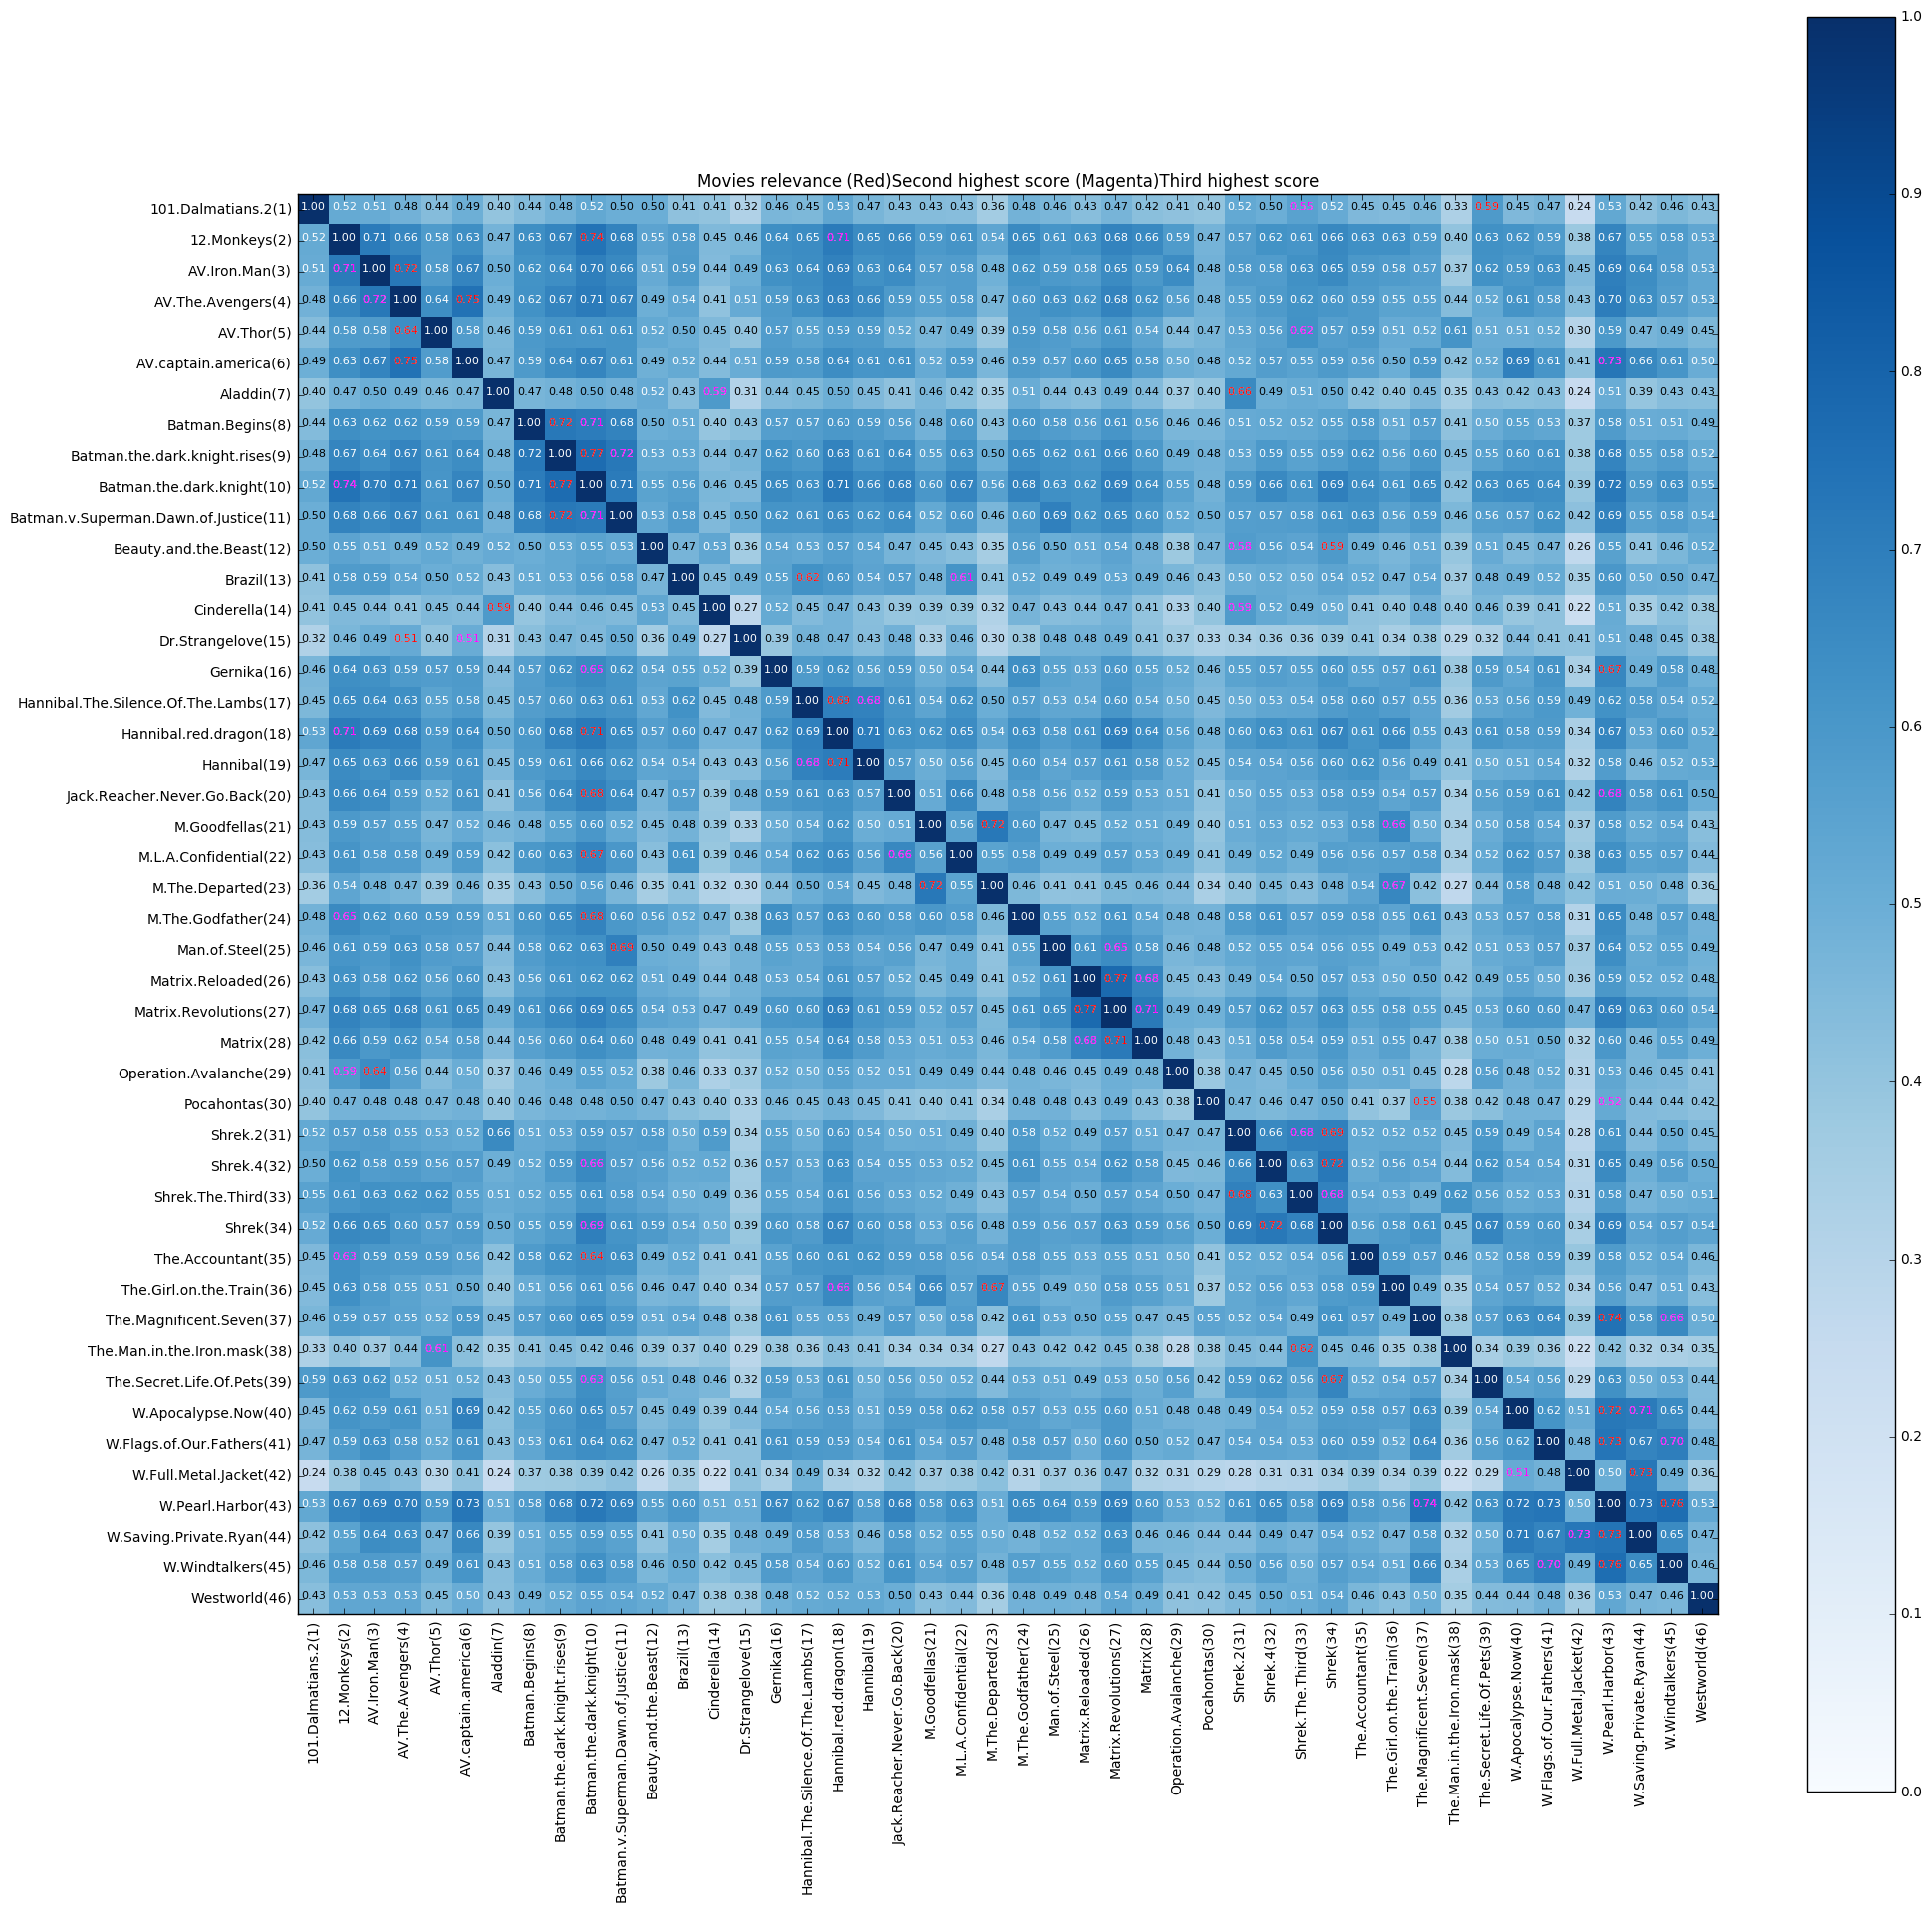

Aproximate running time: 6.38233s


In [8]:
start = time.time()
name_data = obtain_subtitle_data((os.getcwd() + '/subtitles'), dictionary_check=True)
movies_names, subtitles_data = zip(*name_data)
plot_confusion_matrix(texts_relevance(subtitles_data, min_df_=10), movies_names,title='Movies relevance (Red)Second highest score (Magenta)Third highest score')
print('Aproximate running time: {:.5f}s'.format(time.time() - start))

## Observations
We can see that movies from a similar genre or saga tend to be related in the used words, in this case, some of the subtitles have a letter at the begining of the name that help us grouping them and that help us in the visualization. Movies from the same franchise are relevant between them as we can see with Shrek and Matrix, this doesn't happen with Hannibal where the related ones are 'The silence of the lambs' and 'Hannibal', the most relevant for 'Red Dragon' is 'The Dark Knight'. 'Full metal jacket' is a curious case because only few movies are relevant beyond a 47%. With the given results we could apply a k-means algorithm for making movie recommendations or using this information a binary tree could be made for making recommendations using the first and second most relevant movies (even if the score is low) given a root movie, the last one the person has watched, this would be made for further updates.